In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pic
from sklearn.model_selection import train_test_split

from utils import *

In [2]:
from joblib import Parallel, delayed
from templates import guessing_entropy

def compute_mean_ranks(per_trace: np.ndarray, key: np.ndarray, bins=10, repeat=500):
    mean_ranks = np.zeros((per_trace.shape[1], bins), dtype=np.longfloat)
    for bin_ in range(bins):
        print(bin_)
        n_traces = bin_ * per_trace.shape[0] // bins

        #def guess():
        #    subset = np.random.choice(per_trace.shape[0], size=n_traces, replace=False)
        #    return guessing_entropy(np.sum(per_trace[subset], axis=0), key)
            
        #ranks = Parallel(n_jobs=-1)(delayed(guess)() for _ in range(REPEAT))

        rank = np.zeros(per_trace.shape[1], dtype=int)
        for _ in range(repeat):
            print(_, end="\r")
            subset = np.random.choice(per_trace.shape[0], size=n_traces, replace=False)
            rank += guessing_entropy(np.sum(per_trace[subset], axis=0), key)
        mean_ranks[:, bin_] = rank / repeat
    return mean_ranks

def compute_mean_ranks_keyround(per_trace_keyround: np.ndarray, keyrounds: np.ndarray, bins=10, repeat=100):
    mean_ranks = np.zeros((per_trace_keyround.shape[1], bins), dtype=np.longfloat)
    for bin_ in range(bins):
        print(bin_)
        n_traces = bin_ * per_trace_keyround.shape[0] // bins

        #def guess():
        #    subset = np.random.choice(per_trace.shape[0], size=n_traces, replace=False)
        #    return guessing_entropy(np.sum(per_trace[subset], axis=0), key)
            
        #ranks = Parallel(n_jobs=-1)(delayed(guess)() for _ in range(REPEAT))

        rank = np.zeros(per_trace_keyround.shape[1], dtype=np.float64)
        for _ in range(repeat):
            print(_, end="\r")
            subset = np.random.choice(per_trace_keyround.shape[0], size=n_traces, replace=False)
            rank += np.mean(guessing_entropy(per_trace_keyround[subset], keyrounds[subset]), axis=0)
        mean_ranks[:, bin_] = rank / repeat
    return mean_ranks

In [3]:
with open("full_data.pic", "rb") as r:
    seeds_total, traces_total, key, round_perms_labels, copy_perms_labels, masks_labels, rws_perms_labels, rws_masks_labels = pic.load(r)

## 45'000 extraction traces (350'000 profiling)

In [ ]:
TRAIN_SIZE = 350_000

In [ ]:
with open("full_data.pic", "rb") as r:
    seeds_total, traces_total, key, output_total, keyshares_total, perms_total = pic.load(r)
with open("per_trace_350000.pic", "rb") as r:
    per_trace_keyround = pic.load(r)

In [ ]:
_, seeds_extraction = train_test_split(seeds_total, train_size=TRAIN_SIZE, random_state=0)
classifications_per_key_nibble = np.sum(per_trace_keyround, axis=0)
mean_ranks = compute_mean_ranks(per_trace_keyround, key)

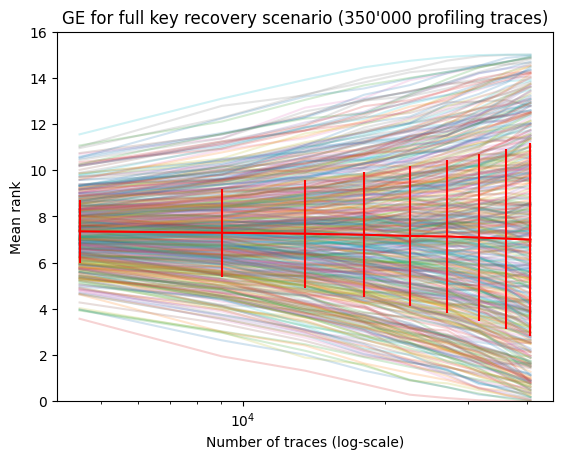

In [116]:
for n, nibble_ranks in enumerate(mean_ranks):
    plt.plot(range(0, per_trace_keyround.shape[0], per_trace_keyround.shape[0] // BINS)[1:-1], nibble_ranks[1:], label=f"Key nibble {n}", alpha=0.2)
plt.errorbar(range(0, per_trace_keyround.shape[0], per_trace_keyround.shape[0] // BINS)[1:-1], np.mean(mean_ranks, axis=0)[1:], np.std(mean_ranks, axis=0)[1:], color="red")
plt.xscale("log")
plt.title("GE for full key recovery scenario (350'000 profiling traces)")
plt.xlabel("Number of traces (log-scale)")
plt.ylabel("Mean rank")
plt.ylim([0, 16])
#plt.legend()
plt.show()

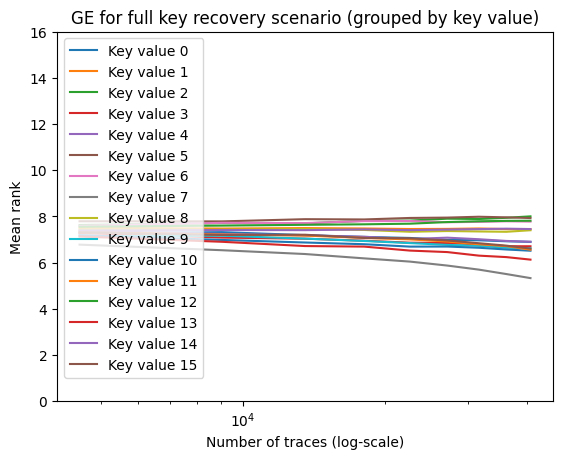

In [34]:
from utils import KEY_ALPHABET
for k in KEY_ALPHABET:
    mean_ranks[key == k]
    plt.plot(range(0, per_trace_keyround.shape[0], per_trace_keyround.shape[0] // BINS)[1:-1], np.mean(mean_ranks[key == k], axis=0)[1:], label=f"Key value {k}")
plt.xscale("log")
plt.title("GE for full key recovery scenario (grouped by key value)")
plt.xlabel("Number of traces (log-scale)")
plt.ylabel("Mean rank")
plt.legend()
plt.ylim([0, 16])
plt.show()

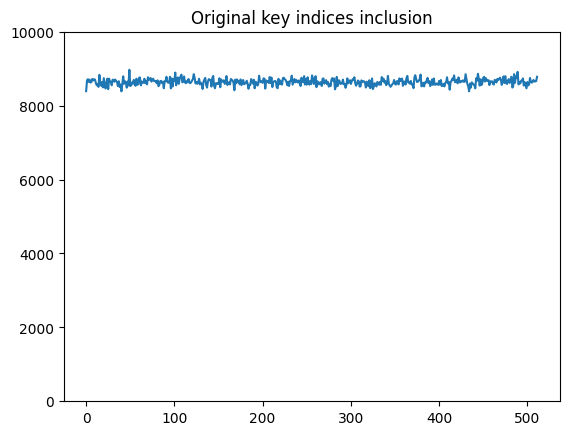

In [88]:
from utils import chacha_random_b4
plt.plot(*np.unique(np.array([chacha_random_b4(seed)[0][:98] for seed in seeds_extraction]), return_counts=True))
#plt.xlim([305, 315])
plt.ylim([0, 10_000])
plt.title("Original key indices inclusion")
plt.show()

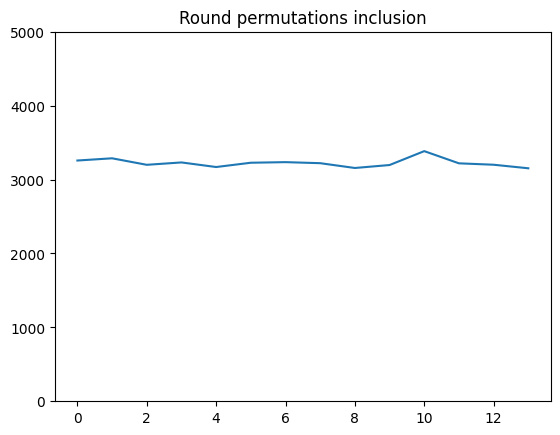

In [97]:
plt.plot(*np.unique(train_test_split(perms_total, train_size=TRAIN_SIZE, random_state=0)[1][:, 1], return_counts=True))
#plt.xlim([305, 315])
plt.ylim([0, 5_000])
plt.title("Round permutations inclusion")
plt.show()

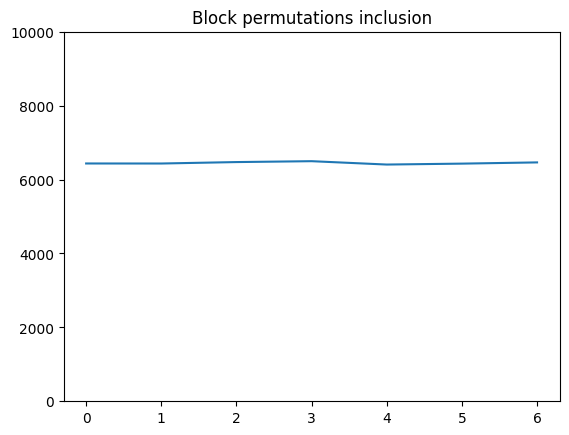

In [98]:
plt.plot(*np.unique(train_test_split(perms_total, train_size=TRAIN_SIZE, random_state=0)[1][:, 2], return_counts=True))
#plt.xlim([305, 315])
plt.ylim([0, 10_000])
plt.title("Block permutations inclusion")
plt.show()

In [104]:
from templates import get_masks_labels
masks_labels = get_masks_labels(seeds_extraction, key, train_test_split(keyshares_total, train_size=TRAIN_SIZE, random_state=0)[1], train_test_split(perms_total, train_size=TRAIN_SIZE, random_state=0)[1][:, 1], train_test_split(perms_total, train_size=TRAIN_SIZE, random_state=0)[1][:, 2:3:1])

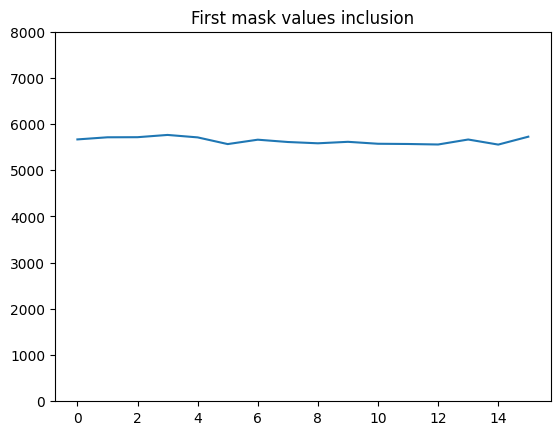

In [111]:
plt.plot(*np.unique(masks_labels[:, 0], return_counts=True))
#plt.xlim([305, 315])
plt.ylim([0, 8000])
plt.title("First mask values inclusion")
plt.show()

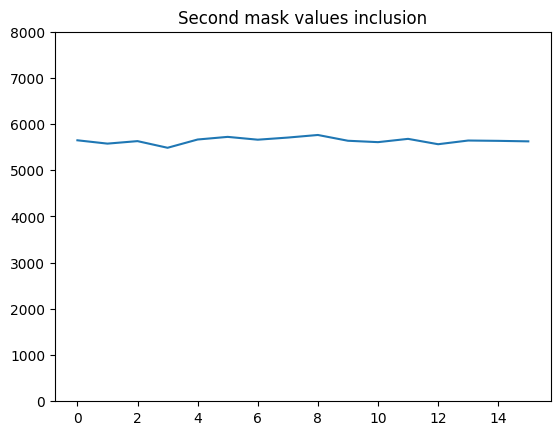

In [109]:
plt.plot(*np.unique(masks_labels[:, 1], return_counts=True))
#plt.xlim([305, 315])
plt.ylim([0, 8000])
plt.title("Second mask values inclusion")
plt.show()

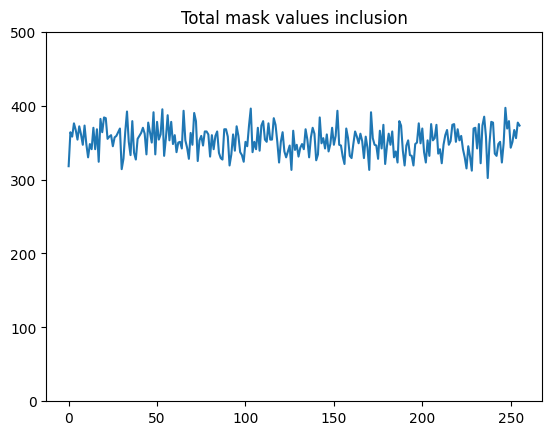

In [112]:
plt.plot(*np.unique(16 * masks_labels[:, 0] + masks_labels[:, 1], return_counts=True))
#plt.xlim([305, 315])
plt.ylim([0, 500])
plt.title("Total mask values inclusion")
plt.show()

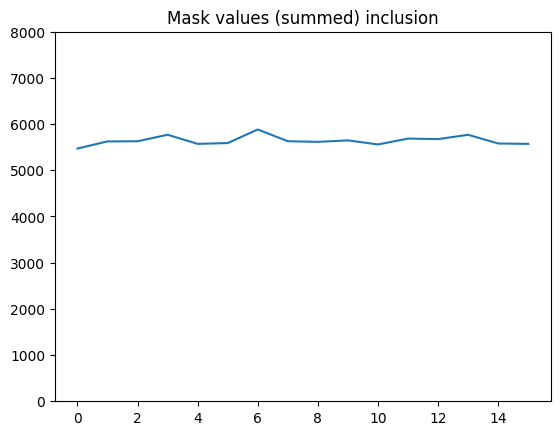

In [114]:
plt.plot(*np.unique((masks_labels[:, 0] + masks_labels[:, 1]) % 16, return_counts=True))
#plt.xlim([305, 315])
plt.ylim([0, 8_000])
plt.title("Mask values (summed) inclusion")
plt.show()

## 100'000 extraction traces (295'000 profiling)

In [4]:
TEST_SIZE = 100_000

In [5]:
with open("y_extraction_epoch_35.pic", "rb") as r:
    y_predicted = pic.load(r)

In [7]:
from templates import classifications_per_trace, reconstruct_key
_, seeds_extraction = train_test_split(seeds_total, test_size=TEST_SIZE, random_state=0)
round_perm_probas = y_predicted[0]
copy_perm_probas = y_predicted[1][:, np.newaxis, :]
masks_probas = np.stack(y_predicted[2:], axis=1)[:, np.newaxis, ...]

per_trace = classifications_per_trace("per_trace_300000.pic", seeds_extraction, np.zeros((seeds_extraction.shape[0], 98)), np.zeros((seeds_extraction.shape[0], 98, 256)), round_perm_probas, copy_perm_probas, masks_probas, masks_rws_keep_only=np.empty((98, 0)), parallel=False)
recovered_key = reconstruct_key(per_trace)

KeyboardInterrupt: 

In [9]:
classifications_per_key_nibble = np.sum(per_trace, axis=0)
mean_ranks = compute_mean_ranks(per_trace, key)
with open("mean_ranks_300000.pic", "wb") as w:
    pic.dump(mean_ranks, w)

0
19
29
39
49
59
69
79
89
99


In [4]:
mean_ranks = np.concatenate((mean_ranks, guessing_entropy(np.sum(per_trace, axis=0), key)[:, np.newaxis]), axis=1)

NameError: name 'mean_ranks' is not defined

In [32]:
mean_ranks = mean_ranks[:, :-1]

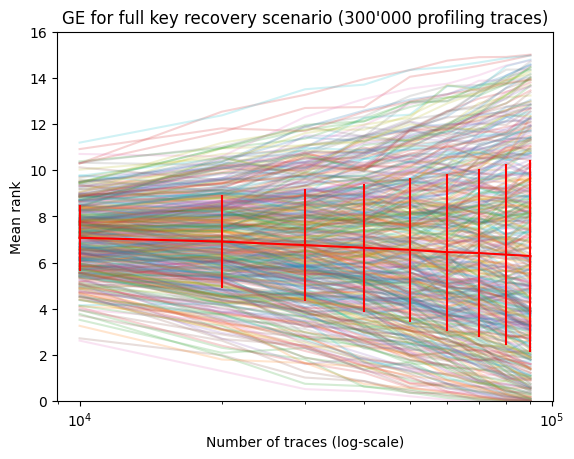

In [42]:
for n, nibble_ranks in enumerate(mean_ranks):
    plt.plot(range(0, per_trace.shape[0], per_trace.shape[0] // BINS)[1:], nibble_ranks[1:], label=f"Key nibble {n}", alpha=0.2)
plt.errorbar(range(0, per_trace.shape[0], per_trace.shape[0] // BINS)[1:], np.mean(mean_ranks, axis=0)[1:], np.std(mean_ranks, axis=0)[1:], color="red")
plt.xscale("log")
plt.title("GE for full key recovery scenario (300'000 profiling traces)")
plt.xlabel("Number of traces (log-scale)")
plt.ylabel("Mean rank")
plt.ylim([0, 16])
#plt.legend()
plt.show()

In [36]:
np.mean(mean_ranks, axis=0)[1:]

array([7.07128906, 6.90603516, 6.75365234, 6.63802734, 6.55037109,
       6.44861328, 6.41083984, 6.34001953, 6.28273438], dtype=float64)

In [6]:
with open("per_trace_300000.pic", "rb") as r:
    per_trace = pic.load(r)

In [13]:
_, seeds_extraction = train_test_split(seeds_total, test_size=TEST_SIZE, random_state=0)


In [14]:
from utils import chacha_random_b4
per_trace_keyround = np.zeros((TEST_SIZE, 98, 16))
for i, (seed, preds) in enumerate(zip(seeds_extraction, per_trace)):
    ind, _ = chacha_random_b4(seed)
    per_trace_keyround[i] = preds[ind[:98]]

In [15]:
per_trace_keyround.shape

(100000, 98, 16)

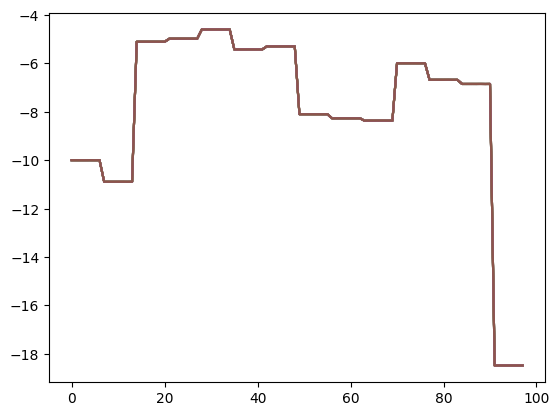

In [16]:
for k in range(16):
    plt.plot(np.mean(per_trace_keyround[:, :, k], axis=0))

In [39]:
train_test_split(round_perms_labels, test_size=TEST_SIZE, random_state=0)[1].shape

(100000,)

In [43]:
np.argmax(y_predicted[1], axis=1).shape

(100000,)

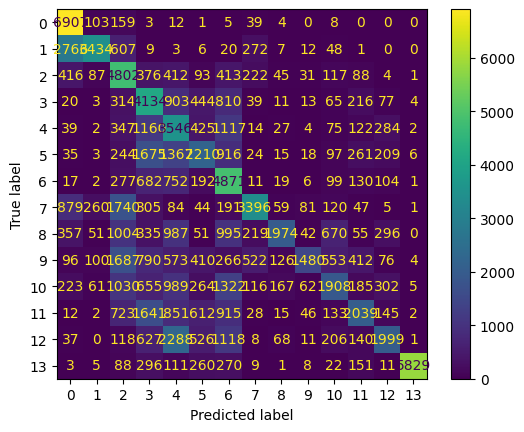

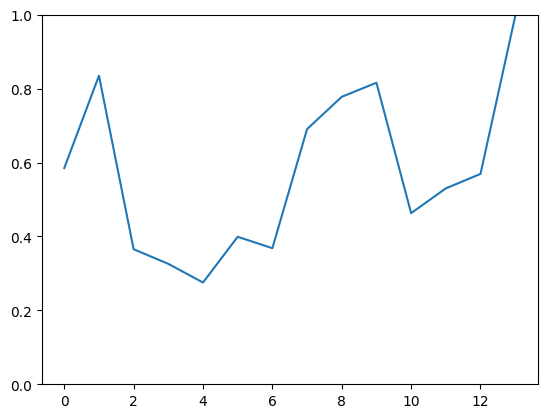

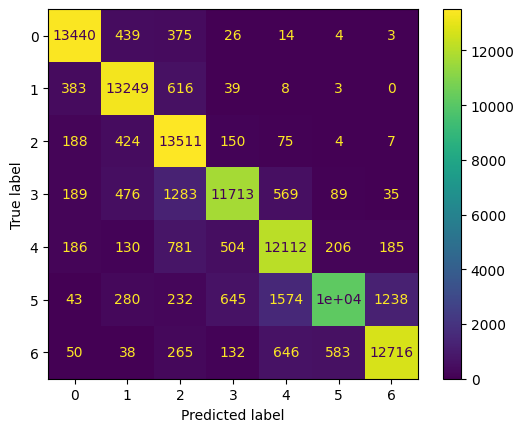

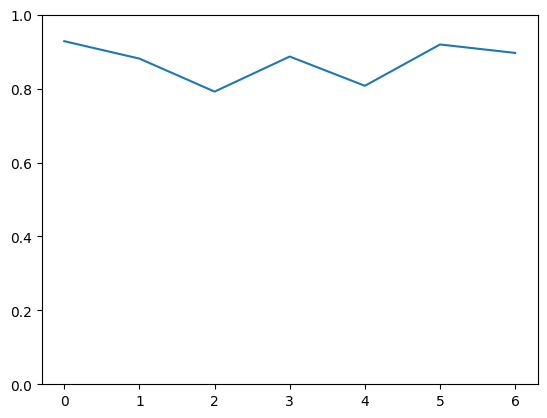

In [54]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score
ConfusionMatrixDisplay(confusion_matrix(train_test_split(round_perms_labels, test_size=TEST_SIZE, random_state=0)[1], np.argmax(y_predicted[0], axis=1))).plot()
plt.show()
plt.plot(precision_score(train_test_split(round_perms_labels, test_size=TEST_SIZE, random_state=0)[1], np.argmax(y_predicted[0], axis=1), average=None))
plt.ylim([0, 1])
plt.show()
ConfusionMatrixDisplay(confusion_matrix(train_test_split(copy_perms_labels[0], test_size=TEST_SIZE, random_state=0)[1], np.argmax(y_predicted[1], axis=1))).plot()
plt.show()
plt.plot(precision_score(train_test_split(copy_perms_labels[0], test_size=TEST_SIZE, random_state=0)[1], np.argmax(y_predicted[1], axis=1), average=None))
plt.ylim([0, 1])
plt.show()

In [18]:
from utils import chacha_random_b4
y_profiling_keyround = np.zeros((TEST_SIZE, 98))
for i, seed in enumerate(seeds_extraction):
    ind, whi = chacha_random_b4(seed)
    y_profiling_keyround[i] = (key[ind[:98]] + whi) % 16

In [27]:
mean_ranks_keyround = compute_mean_ranks_keyround(per_trace_keyround, y_profiling_keyround)

0
1
2
3
4
5
6
7
8
9


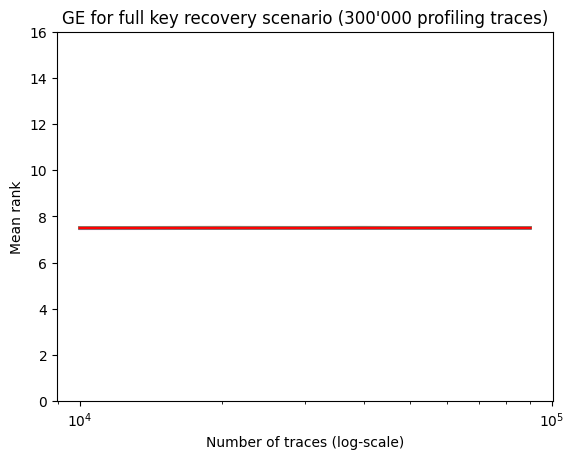

In [31]:
for n, nibble_ranks in enumerate(mean_ranks_keyround):
    plt.plot(range(0, per_trace_keyround.shape[0], per_trace_keyround.shape[0] // BINS)[1:], nibble_ranks[1:], label=f"Key nibble {n}", alpha=0.2)
plt.errorbar(range(0, per_trace_keyround.shape[0], per_trace_keyround.shape[0] // BINS)[1:], np.mean(mean_ranks_keyround, axis=0)[1:], np.std(mean_ranks_keyround, axis=0)[1:], color="red")
plt.xscale("log")
plt.title("GE for full key recovery scenario (300'000 profiling traces)")
plt.xlabel("Number of traces (log-scale)")
plt.ylabel("Mean rank")
plt.ylim([0, 16])
#plt.legend()
plt.show()

In [33]:
np.mean(mean_ranks_keyround, axis=0)[1:]

array([7.4956699 , 7.49880434, 7.49770218, 7.49859671, 7.49814843,
       7.49795276, 7.49773243, 7.49814593, 7.49806116], dtype=float64)

## 100'000 extraction traces (295'000 profiling), doing like the paper

In [4]:
TEST_SIZE = 100_000

In [5]:
with open("y_extraction_epoch_35.pic", "rb") as r:
    y_predicted = pic.load(r)

In [11]:
from templates import classifications_per_trace, reconstruct_key
_, seeds_extraction = train_test_split(seeds_total, test_size=TEST_SIZE, random_state=0)
round_perm_probas = y_predicted[0]
copy_perm_probas = y_predicted[1][:, np.newaxis, :]
masks_probas = np.stack(y_predicted[2:], axis=1)[:, np.newaxis, ...]

#per_trace = classifications_per_trace("per_trace_300000_only_best_round_perms.pic", seeds_extraction, np.zeros((seeds_extraction.shape[0], 98)), np.zeros((seeds_extraction.shape[0], 98, 256)), round_perm_probas, copy_perm_probas, masks_probas, round_keep_only=np.array([1, 8, 9, 13]), masks_rws_keep_only=np.empty((98, 0)), parallel=True)
per_trace = classifications_per_trace("per_trace_300000_like_paperfsd.pic", seeds_extraction, np.zeros((seeds_extraction.shape[0], 98)), np.zeros((seeds_extraction.shape[0], 98, 256)), round_perm_probas, copy_perm_probas, masks_probas, parallel=False)
recovered_key = reconstruct_key(per_trace)

KeyboardInterrupt: 

In [13]:
np.count_nonzero(recovered_key == key) / 512

0.16015625

In [20]:
np.sum(per_trace, axis=0)[0]

array([-52378.88154183, -52377.5250318 , -52377.4242367 , -52376.05426314,
       -52375.79850184, -52378.5331113 , -52384.22837718, -52380.89514031,
       -52381.94102389, -52376.01129688, -52386.38977742, -52378.33811725,
       -52379.35596321, -52381.3006239 , -52380.13186052, -52377.78228378])

In [21]:
classifications_per_key_nibble = np.sum(per_trace, axis=0)

In [73]:
ranks = guessing_entropy(classifications_per_key_nibble, key)
counts = np.sum(np.all(per_trace != 0, axis=2).astype(int), axis=0)

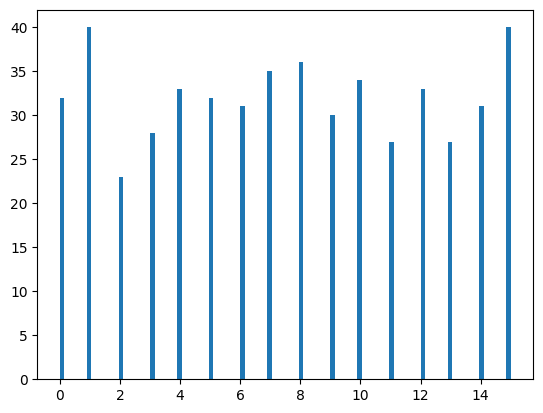

In [118]:
plt.hist(key, bins=100)
plt.show()

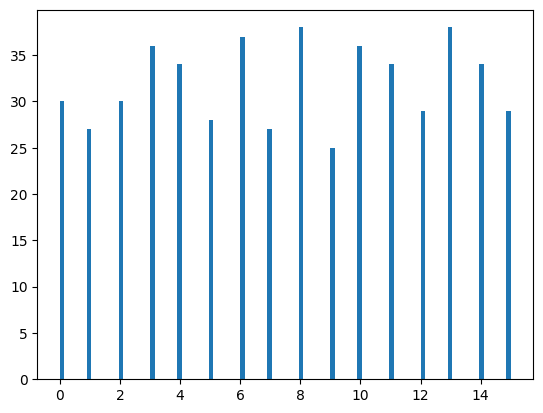

In [119]:
plt.hist(recovered_key, bins=100)
plt.show()

Text(0, 0.5, 'Number of witnesses')

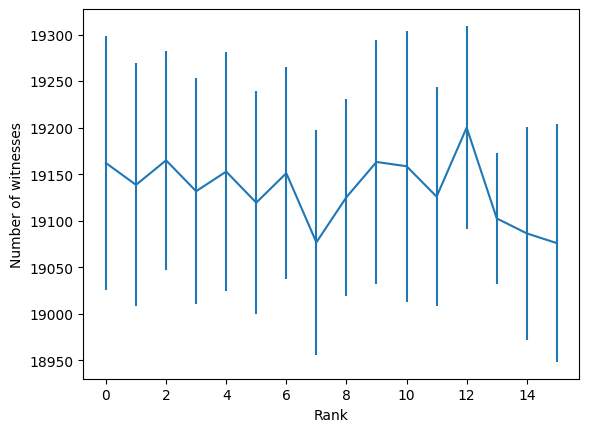

In [98]:
plt.errorbar(np.unique(ranks), [np.mean(counts[ranks == r]) for r in np.unique(ranks)], yerr=[np.std(counts[ranks == r]) for r in np.unique(ranks)])
plt.xlabel("Rank")
plt.ylabel("Number of witnesses")

Text(0, 0.5, 'Number of witnesses')

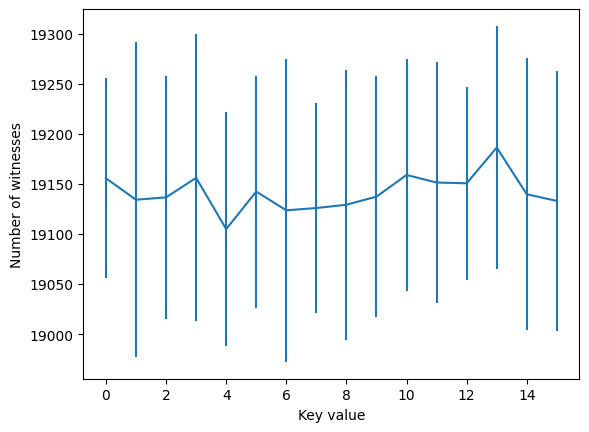

In [120]:
plt.errorbar(KEY_ALPHABET, [np.mean(counts[key == k]) for k in KEY_ALPHABET], yerr=[np.std(counts[key == k]) for k in KEY_ALPHABET])
plt.xlabel("Key value")
plt.ylabel("Number of witnesses")

Text(0, 0.5, 'Mean rank')

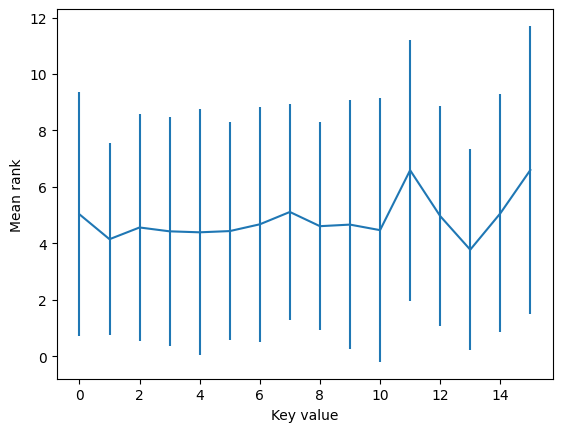

In [97]:
from utils import KEY_ALPHABET
plt.errorbar(KEY_ALPHABET, [np.mean(ranks[key == k]) for k in KEY_ALPHABET], [np.std(ranks[key == k]) for k in KEY_ALPHABET])
plt.xlabel("Key value")
plt.ylabel("Mean rank")

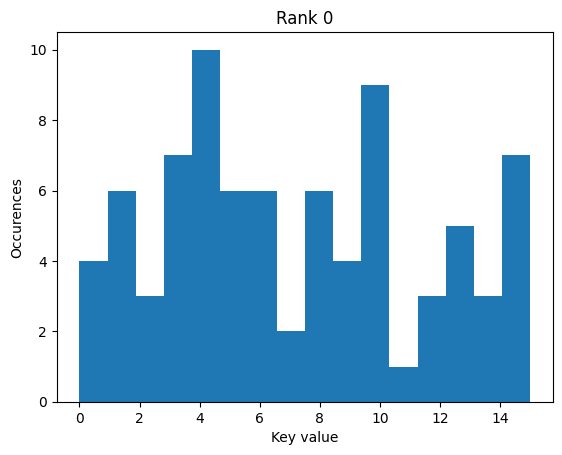

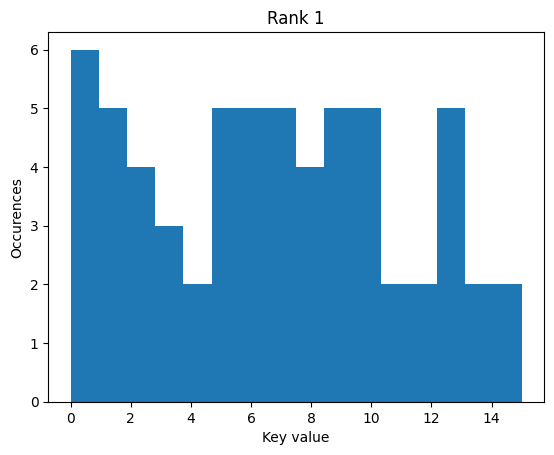

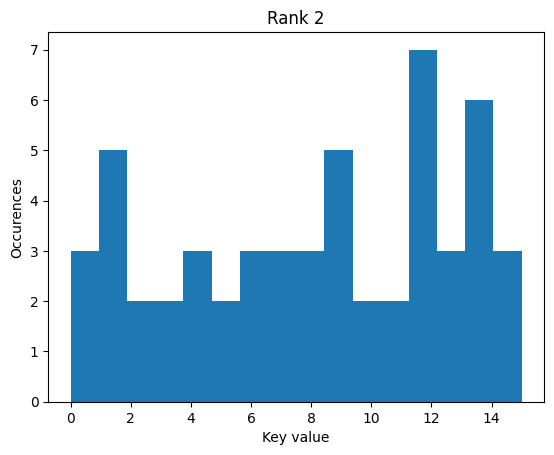

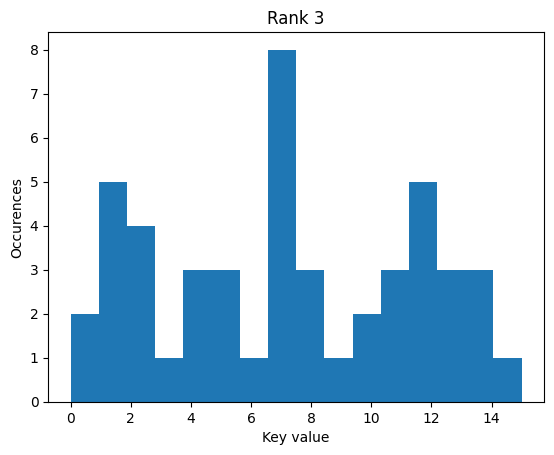

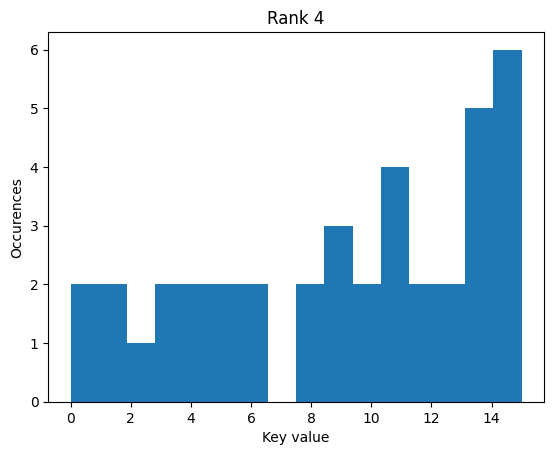

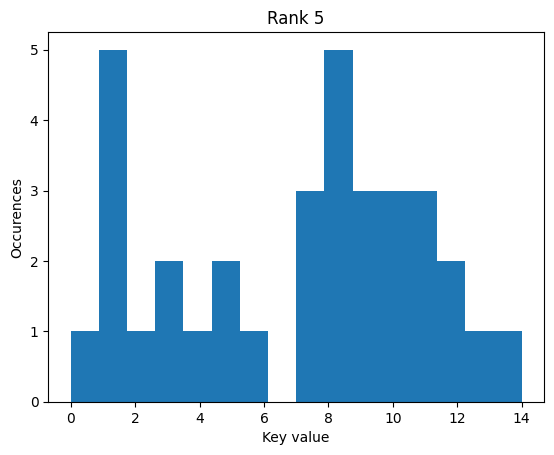

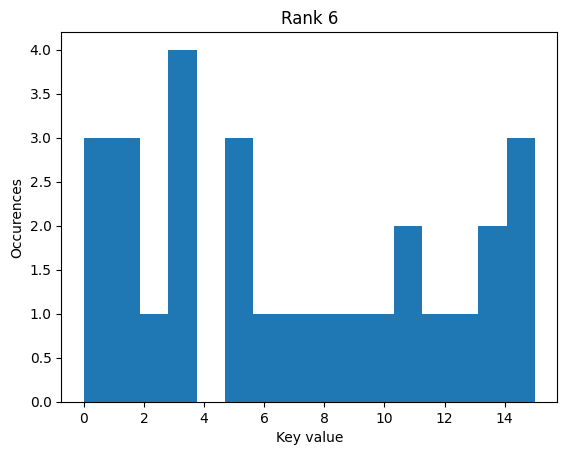

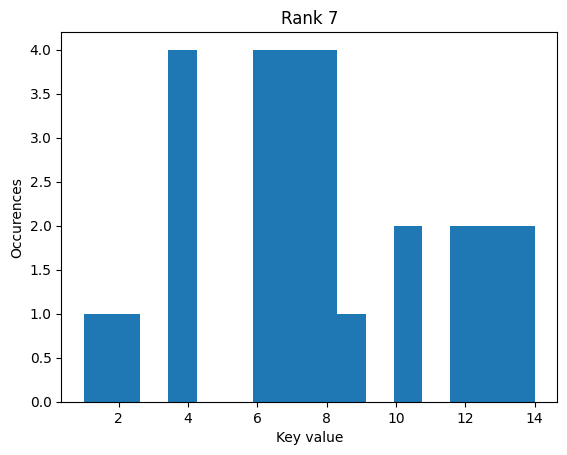

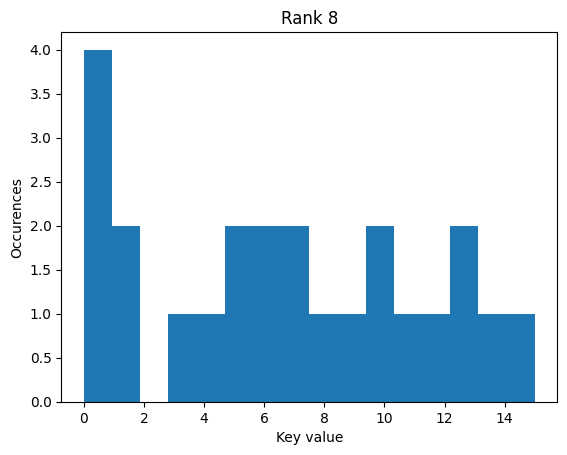

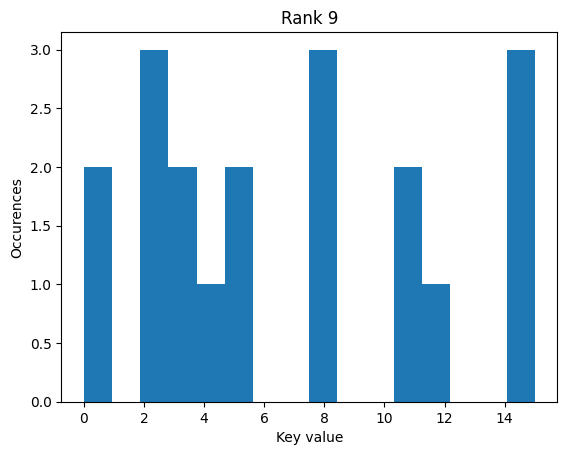

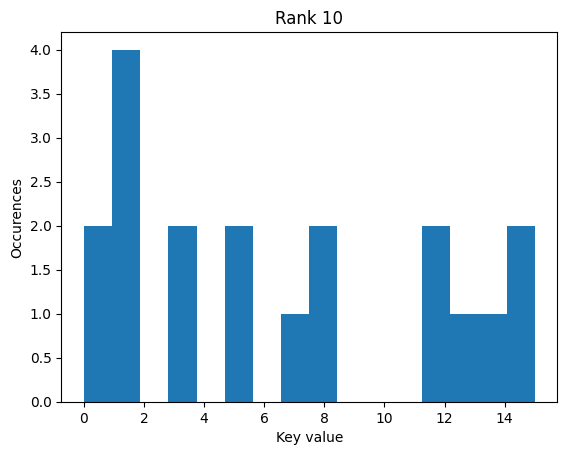

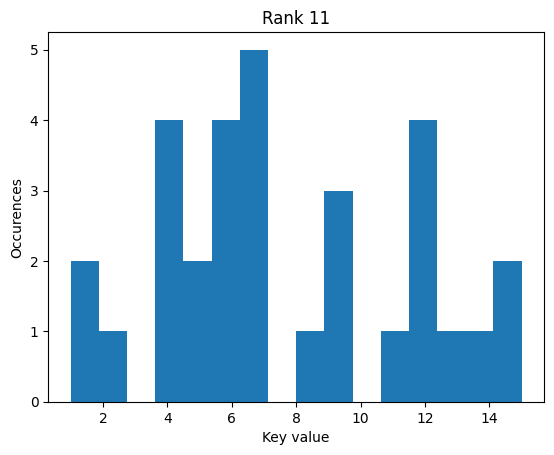

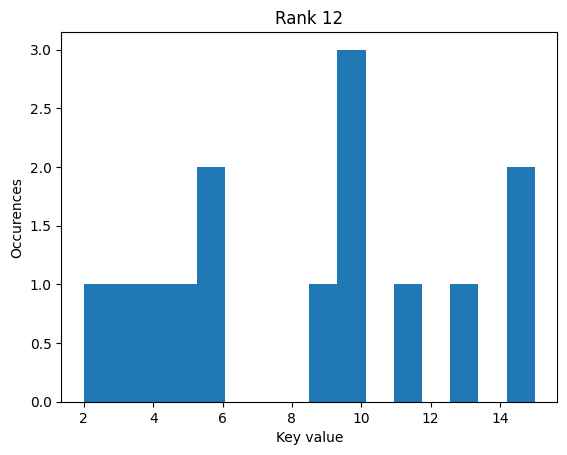

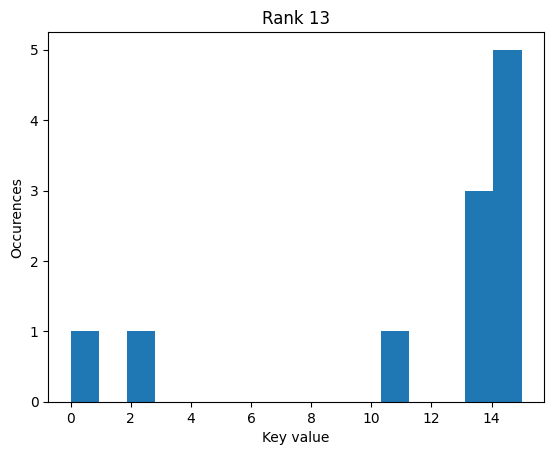

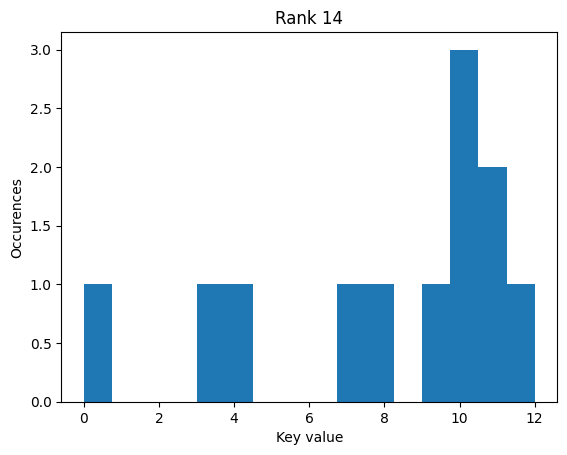

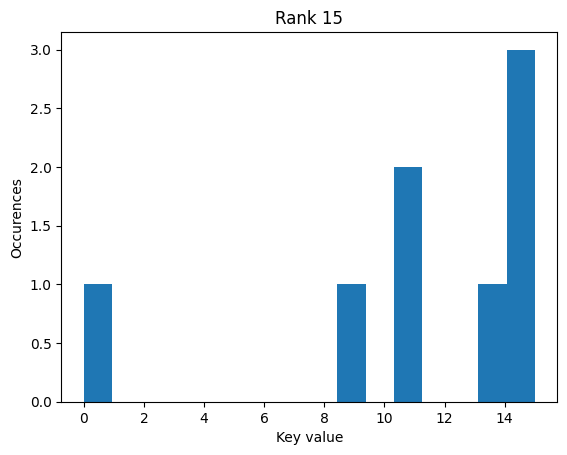

In [106]:
from utils import KEY_ALPHABET
for r in np.unique(ranks):
    plt.hist(key[ranks == r], bins=16)
    plt.title(f"Rank {r}")
    plt.xlabel("Key value")
    plt.ylabel("Occurences")
    plt.show()

In [10]:
classifications_per_key_nibble = np.sum(per_trace, axis=0)
mean_ranks = compute_mean_ranks(per_trace, key, repeat=100)
with open("mean_ranks_300000_only_best_round_perms.pic", "wb") as w:
    pic.dump(mean_ranks, w)

0
19
29
39
49
59
69
79
89
99


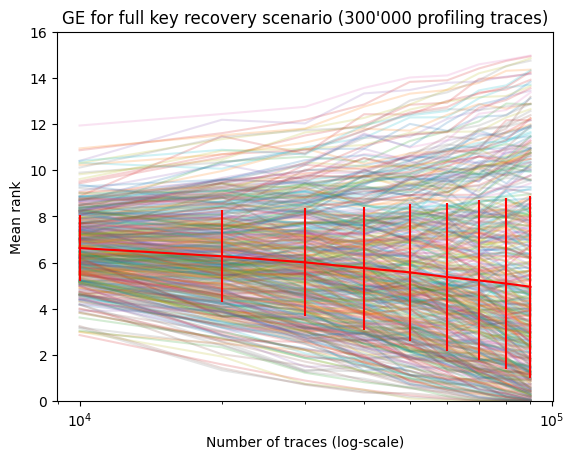

In [13]:
for n, nibble_ranks in enumerate(mean_ranks):
    plt.plot(range(0, per_trace.shape[0], per_trace.shape[0] // 10)[1:], nibble_ranks[1:], label=f"Key nibble {n}", alpha=0.2)
plt.errorbar(range(0, per_trace.shape[0], per_trace.shape[0] // 10)[1:], np.mean(mean_ranks, axis=0)[1:], np.std(mean_ranks, axis=0)[1:], color="red")
plt.xscale("log")
plt.title("GE for full key recovery scenario (300'000 profiling traces)")
plt.xlabel("Number of traces (log-scale)")
plt.ylabel("Mean rank")
plt.ylim([0, 16])
#plt.legend()
plt.show()

In [14]:
from utils import chacha_random_b4
per_trace_keyround = np.zeros((TEST_SIZE, 98, 16))
for i, (seed, preds) in enumerate(zip(seeds_extraction, per_trace)):
    ind, _ = chacha_random_b4(seed)
    per_trace_keyround[i] = preds[ind[:98]]

In [15]:
per_trace_keyround.shape

(100000, 98, 16)

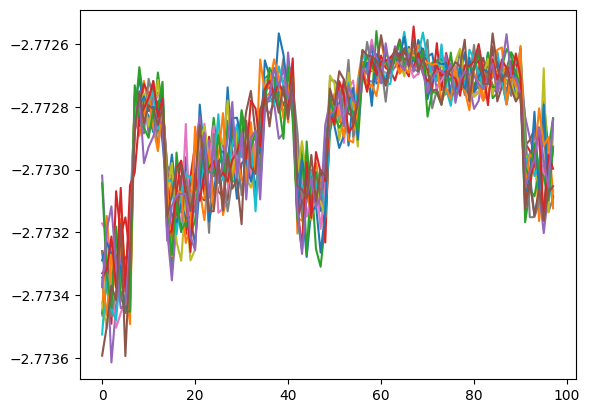

In [16]:
for k in range(16):
    plt.plot(np.mean(per_trace_keyround[:, :, k], axis=0))

In [9]:
with open("per_trace_300000_only_best_round_perms.pic", "rb") as r:
    per_trace = pic.load(r)

In [92]:
from utils import chacha_random_b4
_, seeds_extraction = train_test_split(seeds_total, test_size=TEST_SIZE, random_state=0)
per_trace_keyround = np.zeros((TEST_SIZE, 98, 16))
for i, (seed, preds) in enumerate(zip(seeds_extraction, per_trace)):
    ind, _ = chacha_random_b4(seed)
    per_trace_keyround[i] = preds[ind[:98]]
    
y_profiling_keyround = np.zeros((TEST_SIZE, 98))
for i, seed in enumerate(seeds_extraction):
    ind, whi = chacha_random_b4(seed)
    y_profiling_keyround[i] = key[ind[:98]]

In [95]:
mean_ranks_keyround = compute_mean_ranks_keyround(per_trace_keyround, y_profiling_keyround, repeat=10)

0


c:\Users\Kudelski\Documents\Pierugo-PDM-2024\protected_side_channel_attack\.venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Kudelski\Documents\Pierugo-PDM-2024\protected_side_channel_attack\.venv\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


c:\Users\Kudelski\Documents\Pierugo-PDM-2024\protected_side_channel_attack\.venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Kudelski\Documents\Pierugo-PDM-2024\protected_side_channel_attack\.venv\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


1


KeyboardInterrupt: 

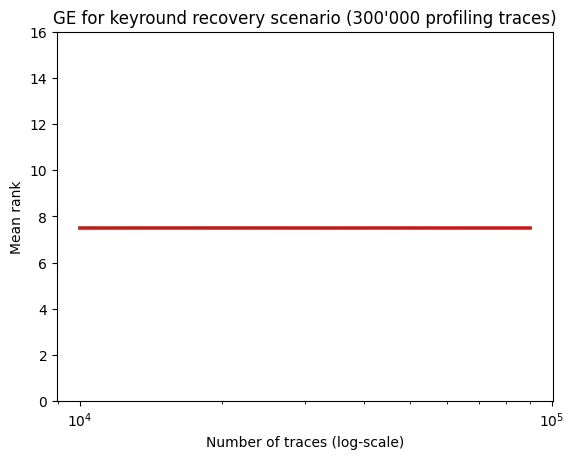

In [94]:
for n, nibble_ranks in enumerate(mean_ranks_keyround):
    plt.plot(range(0, per_trace_keyround.shape[0], per_trace_keyround.shape[0] // 10)[1:], nibble_ranks[1:], label=f"Key nibble {n}", alpha=0.2)
plt.errorbar(range(0, per_trace_keyround.shape[0], per_trace_keyround.shape[0] // 10)[1:], np.mean(mean_ranks_keyround, axis=0)[1:], np.std(mean_ranks_keyround, axis=0)[1:], color="red")
plt.xscale("log")
plt.title("GE for keyround recovery scenario (300'000 profiling traces)")
plt.xlabel("Number of traces (log-scale)")
plt.ylabel("Mean rank")
plt.ylim([0, 16])
#plt.legend()
plt.show()

In [96]:
np.mean(mean_ranks_keyround, axis=0)[1:]

array([7.49144429, 7.49295214, 7.49254425, 7.49253635, 7.49199255,
       7.49183422, 7.49179329, 7.49226054, 7.49237565], dtype=float64)

## 100'000 extraction traces (295'000 profiling), independent masks (2 * 16 >< 1 * 256), doing like the paper

In [4]:
TEST_SIZE = 100_000

In [5]:
with open("y_extraction_300000_ind_masks.pic", "rb") as r:
    y_predicted = pic.load(r)

In [6]:
from templates import classifications_per_trace, reconstruct_key
_, seeds_extraction = train_test_split(seeds_total, test_size=TEST_SIZE, random_state=0)
round_perm_probas = y_predicted[0]
copy_perm_probas = y_predicted[1][:, np.newaxis, :]
masks_probas = np.stack([np.stack(y_predicted[i:i+2], axis=1) for i in range(2, len(y_predicted), 2)], axis=1)[:, np.newaxis, ...]

per_trace = classifications_per_trace("per_trace_300000_ind_masks.pic", seeds_extraction, round_perm_probas, copy_perm_probas, masks_probas, parallel=True)
recovered_key = reconstruct_key(per_trace)

In [7]:
np.count_nonzero(recovered_key == key) / 512

0.21484375

In [8]:
classifications_per_key_nibble = np.sum(per_trace, axis=0)
mean_ranks = compute_mean_ranks(per_trace, key, repeat=100)
with open("mean_ranks_300000_ind_masks.pic", "wb") as w:
    pic.dump(mean_ranks, w)

0
19
29
39
49
59
69
79
89
99


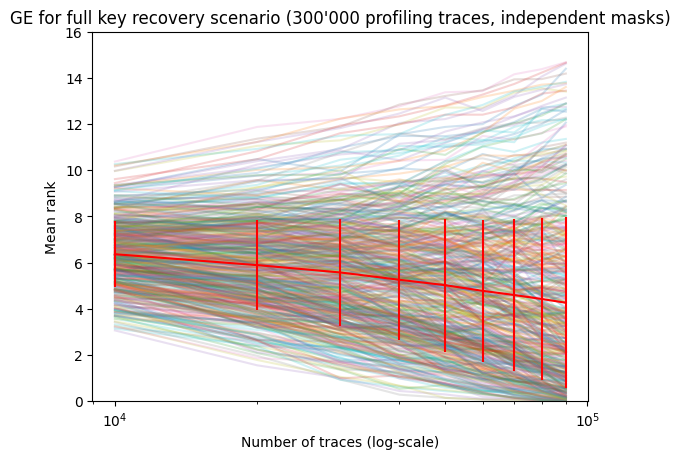

In [10]:
for n, nibble_ranks in enumerate(mean_ranks):
    plt.plot(range(0, per_trace.shape[0], per_trace.shape[0] // 10)[1:], nibble_ranks[1:], label=f"Key nibble {n}", alpha=0.2)
plt.errorbar(range(0, per_trace.shape[0], per_trace.shape[0] // 10)[1:], np.mean(mean_ranks, axis=0)[1:], np.std(mean_ranks, axis=0)[1:], color="red")
plt.xscale("log")
plt.title("GE for full key recovery scenario (300'000 profiling traces, independent masks)")
plt.xlabel("Number of traces (log-scale)")
plt.ylabel("Mean rank")
plt.ylim([0, 16])
#plt.legend()
plt.show()

## 100'000 extraction traces using RWS

In [4]:
TEST_SIZE = 100_000

In [5]:
with open("y_extraction_rws_300000.pic", "rb") as r:
    y_predicted = pic.load(r)

In [8]:
from templates import rws_classifications_per_trace, reconstruct_key
_, seeds_extraction = train_test_split(seeds_total, test_size=TEST_SIZE, random_state=0)
rws_perm_probas = y_predicted[0]
rws_masks_probas = np.stack([np.stack(y_predicted[i:i+2], axis=1) for i in range(1, len(y_predicted), 2)], axis=1)

per_trace = rws_classifications_per_trace("per_trace_300000_rws.pic", seeds_extraction, rws_perm_probas, rws_masks_probas, parallel=True)
recovered_key = reconstruct_key(per_trace)

In [9]:
np.count_nonzero(recovered_key == key) / 512

0.556640625

In [10]:
classifications_per_key_nibble = np.sum(per_trace, axis=0)
mean_ranks = compute_mean_ranks(per_trace, key, repeat=100)
with open("mean_ranks_300000_rws.pic", "wb") as w:
    pic.dump(mean_ranks, w)

0
19
29
39
49
59
69
79
89
99


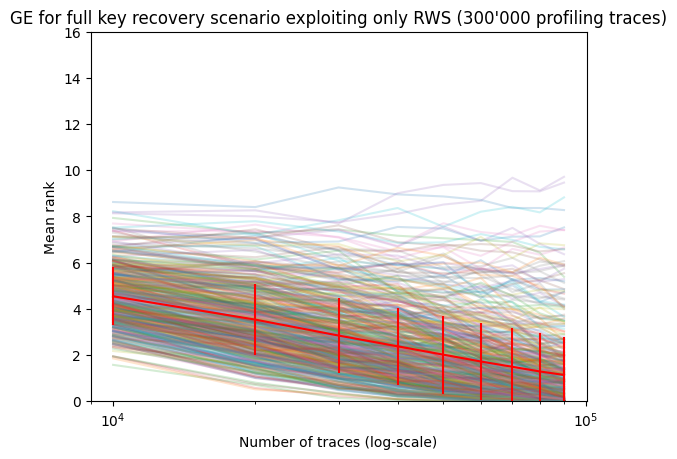

In [18]:
for n, nibble_ranks in enumerate(mean_ranks):
    plt.plot(range(0, per_trace.shape[0], per_trace.shape[0] // 10)[1:], nibble_ranks[1:], label=f"Key nibble {n}", alpha=0.2)
plt.errorbar(range(0, per_trace.shape[0], per_trace.shape[0] // 10)[1:], np.mean(mean_ranks, axis=0)[1:], np.std(mean_ranks, axis=0)[1:], color="red")
plt.xscale("log")
plt.title("GE for full key recovery scenario exploiting only RWS (300'000 profiling traces)")
plt.xlabel("Number of traces (log-scale)")
plt.ylabel("Mean rank")
plt.ylim([0, 16])
#plt.legend()
plt.show()

## 100'000 extraction traces combining RWS and rounds leakage

In [4]:
TEST_SIZE = 100_000

In [33]:
with open("y_extraction_rws_300000.pic", "rb") as r:
    y_predicted_rws = pic.load(r)
with open("y_extraction_300000_ind_masks.pic", "rb") as r:
    y_predicted_rounds = pic.load(r)

In [36]:
from templates import rws_classifications_per_trace, reconstruct_key
_, rws_perms_true, _, round_perms_true, _, copy_perms_true, _, rws_masks_true, _, round_masks_true = train_test_split(rws_perms_labels, round_perms_labels, np.moveaxis(copy_perms_labels, -1, 0), np.moveaxis(rws_masks_labels[:24], -1, 0), np.moveaxis(masks_labels, -1, 0), test_size=TEST_SIZE, random_state=0)
_, seeds_extraction = train_test_split(seeds_total, test_size=TEST_SIZE, random_state=0)
rws_perm_probas = y_predicted_rws[0]
rws_masks_probas = np.stack([np.stack(y_predicted_rws[i:i+2], axis=1) for i in range(1, len(y_predicted_rws), 2)], axis=1)
round_perm_probas = y_predicted_rounds[0]
copy_perm_probas = y_predicted_rounds[1][:, np.newaxis, :]
masks_probas = np.stack([np.stack(y_predicted_rounds[i:i+2], axis=1) for i in range(2, len(y_predicted_rounds), 2)], axis=1)[:, np.newaxis, ...]

0.793

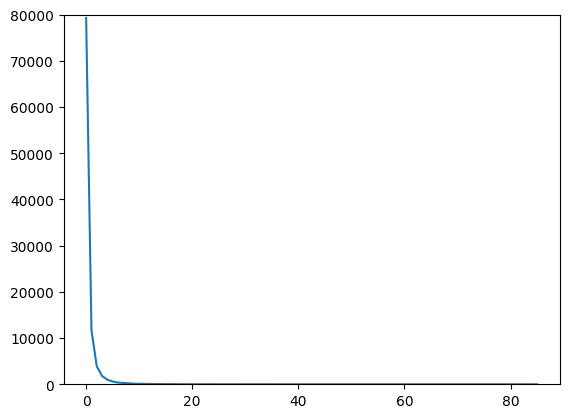

In [37]:
plt.plot(*np.unique(guessing_entropy(rws_perm_probas, rws_perms_true), return_counts=True))
plt.ylim([0, 80_000])
np.count_nonzero(np.argmax(rws_perm_probas, axis=1) == rws_perms_true)/rws_perms_true.shape[0]

In [38]:
np.count_nonzero(np.argmax(rws_masks_probas, axis=-1) == rws_masks_true) / rws_masks_true.size

0.09248

(0.0, 500000.0)

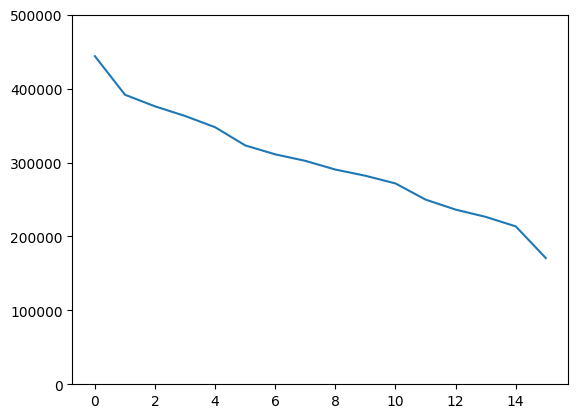

In [39]:
plt.plot(*np.unique(guessing_entropy(rws_masks_probas, rws_masks_true), return_counts=True))
plt.ylim([0, 0.5e6])

(0.0, 60000.0)

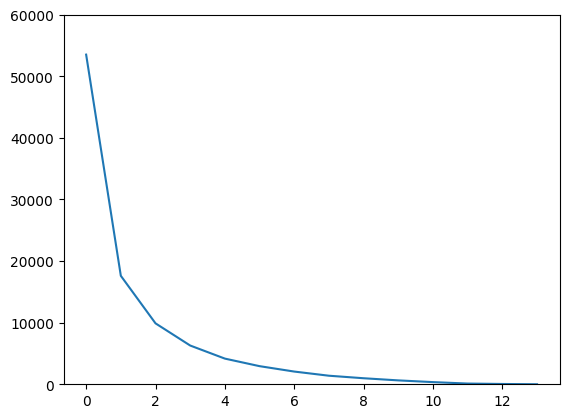

In [42]:
plt.plot(*np.unique(guessing_entropy(round_perm_probas, round_perms_true), return_counts=True))
plt.ylim([0, 60000])

(0.0, 100000.0)

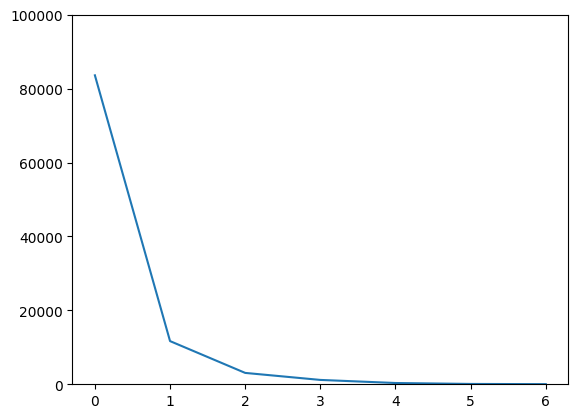

In [43]:
plt.plot(*np.unique(guessing_entropy(copy_perm_probas, copy_perms_true), return_counts=True))
plt.ylim([0, 100000])

In [44]:
np.count_nonzero(np.argmax(masks_probas, axis=-1) == round_masks_true) / round_masks_true.size

0.09529857142857143

(0.0, 150000.0)

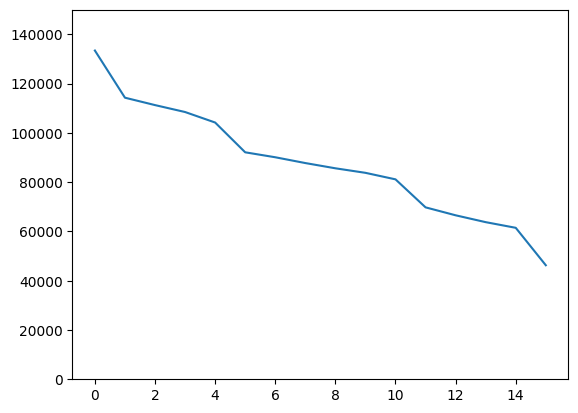

In [47]:
plt.plot(*np.unique(guessing_entropy(masks_probas, round_masks_true), return_counts=True))
plt.ylim([0, 0.15e6])

In [ ]:
from templates import rws_classifications_per_trace, reconstruct_key
_, seeds_extraction = train_test_split(seeds_total, test_size=TEST_SIZE, random_state=0)
rws_perm_probas = y_predicted_rws[0]
rws_masks_probas = np.stack([np.stack(y_predicted_rws[i:i+2], axis=1) for i in range(1, len(y_predicted_rws), 2)], axis=1)

per_trace_rws = rws_classifications_per_trace("per_trace_300000_rws.pic", seeds_extraction, rws_perm_probas, rws_masks_probas, parallel=True)

round_perm_probas = y_predicted_rounds[0]
copy_perm_probas = y_predicted_rounds[1][:, np.newaxis, :]
masks_probas = np.stack(y_predicted_rounds[2:], axis=1)[:, np.newaxis, ...]

per_trace_rounds = classifications_per_trace("per_trace_300000_like_paper.pic", seeds_extraction, np.zeros((seeds_extraction.shape[0], 98)), np.zeros((seeds_extraction.shape[0], 98, 256)), round_perm_probas, copy_perm_probas, masks_probas, parallel=False)

per_trace_total = per_trace_rws + per_trace_rounds
recovered_key = reconstruct_key(per_trace_total)

In [81]:
with open("per_trace_300000_rws.pic", "rb") as r:
    per_trace_rws = pic.load(r)
with open("per_trace_300000_ind_masks.pic", "rb") as r:
    per_trace_rounds = pic.load(r)
per_trace_total = per_trace_rws + per_trace_rounds
recovered_key = reconstruct_key(per_trace_total)

In [82]:
np.count_nonzero(recovered_key == key) / 512

0.60546875

## More data

In [8]:
with open("seeds_key_739094.pic", "rb") as r:
    seeds_total, key = pic.load(r)

## 240'000 extraction traces, Haar 2nd order

In [3]:
TRAIN_SIZE = 500_000

In [4]:
with open("y_extraction_500000_haar_2_epoch_33.pic", "rb") as r:
    y_predicted = pic.load(r)

In [9]:
from templates import guessing_entropy
with open("labels_739094.pic", "rb") as r:
    rws_perms_labels, round_perms_labels, copy_perms_labels, rws_masks_labels, round_masks_labels = pic.load(r)
_, rws_perms_true, _, round_perms_true, _, copy_perms_true, _, rws_masks_true, _, round_masks_true = train_test_split(rws_perms_labels, round_perms_labels, np.moveaxis(copy_perms_labels, -1, 0), np.moveaxis(rws_masks_labels, -1, 0), np.moveaxis(round_masks_labels, -1, 0), train_size=TRAIN_SIZE, random_state=0)
_, seeds_extraction = train_test_split(seeds_total, train_size=TRAIN_SIZE, random_state=0)
rws_perm_probas = y_predicted[0]
rws_masks_probas = np.stack([np.stack(y_predicted[keyround_idx:keyround_idx+NR_SHARES], axis=1) for keyround_idx in range(1, 1 + NR_SHARES * KEYROUND_WIDTH_B4, NR_SHARES)], axis=1)
round_perm_probas = y_predicted[1 + NR_SHARES * KEYROUND_WIDTH_B4]
copy_perm_probas = np.stack(y_predicted[1 + NR_SHARES * KEYROUND_WIDTH_B4 + 1:1 + NR_SHARES * KEYROUND_WIDTH_B4 + 1 + (LATEST_ROUND - EARLIEST_ROUND)], axis=1)
masks_probas = np.stack([np.stack([np.stack(y_predicted[block_idx:block_idx+NR_SHARES], axis=1) for block_idx in range(1 + NR_SHARES * KEYROUND_WIDTH_B4 + 1 + (LATEST_ROUND - EARLIEST_ROUND) + 2 * round_idx * BLOCK_WIDTH_B4, 1 + NR_SHARES * KEYROUND_WIDTH_B4 + 1 + (LATEST_ROUND - EARLIEST_ROUND) + 2 * (round_idx + 1) * BLOCK_WIDTH_B4, NR_SHARES)], axis=1) for round_idx in range(EARLIEST_ROUND, LATEST_ROUND)], axis=1)

In [10]:
masks_probas.shape

(239093, 14, 7, 2, 16)

In [12]:
round_masks_true.shape

(239093, 14, 7, 2)

In [26]:
np.mean(np.mean(np.argmax(rws_perm_probas, axis=-1) == rws_perms_true, axis=0)), np.std(np.mean(np.argmax(rws_perm_probas, axis=-1) == rws_perms_true, axis=0))

(0.7412178524674499, 0.0)

In [27]:
np.mean(np.mean(np.argmax(round_perm_probas, axis=-1) == round_perms_true, axis=0)), np.std(np.mean(np.argmax(round_perm_probas, axis=-1) == round_perms_true, axis=0))

(0.589310435688205, 0.0)

In [28]:
np.mean(np.mean(np.argmax(copy_perm_probas, axis=-1) == copy_perms_true, axis=0)), np.std(np.mean(np.argmax(copy_perm_probas, axis=-1) == copy_perms_true, axis=0))

(0.37709564299845066, 0.04072492074293587)

In [25]:
np.mean(np.mean(np.argmax(rws_masks_probas, axis=-1) == rws_masks_true, axis=0)), np.std(np.mean(np.argmax(rws_masks_probas, axis=-1) == rws_masks_true, axis=0))

(0.06849953869030725, 0.002567497087724598)

In [ ]:
np.mean(np.mean(np.argmax(masks_probas, axis=-1) == round_masks_true, axis=0)), np.std(np.mean(np.argmax(masks_probas, axis=-1) == round_masks_true, axis=0))

(0.0698145423218034, 0.0030659083362207344)

0.7412178524674499

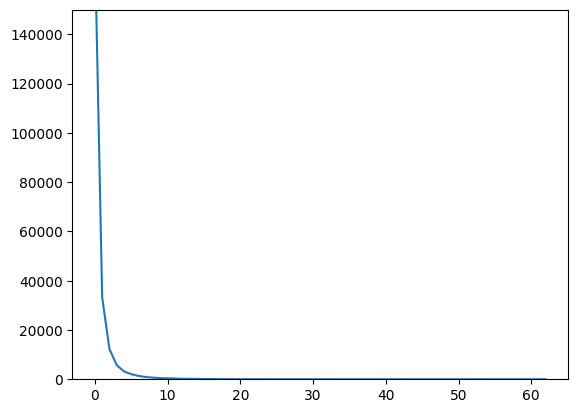

In [7]:
plt.plot(*np.unique(guessing_entropy(rws_perm_probas, rws_perms_true), return_counts=True))
plt.ylim([0, 150_000])
np.count_nonzero(np.argmax(rws_perm_probas, axis=1) == rws_perms_true)/rws_perms_true.shape[0]

In [8]:
np.count_nonzero(np.argmax(rws_masks_probas, axis=-1) == rws_masks_true) / rws_masks_true.size

0.06849953869030725

(0.0, 3500000.0)

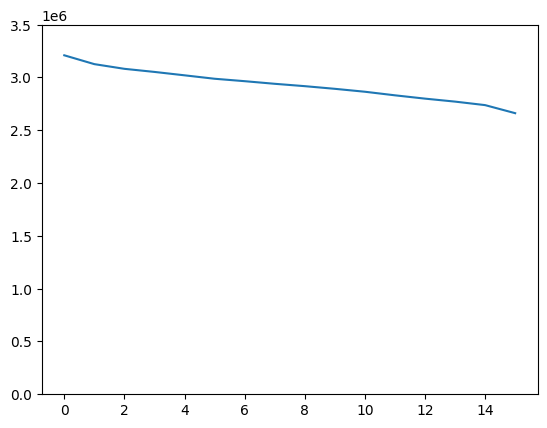

In [9]:
plt.plot(*np.unique(guessing_entropy(rws_masks_probas, rws_masks_true), return_counts=True))
plt.ylim([0, 3.5e6])

(0.0, 130000.0)

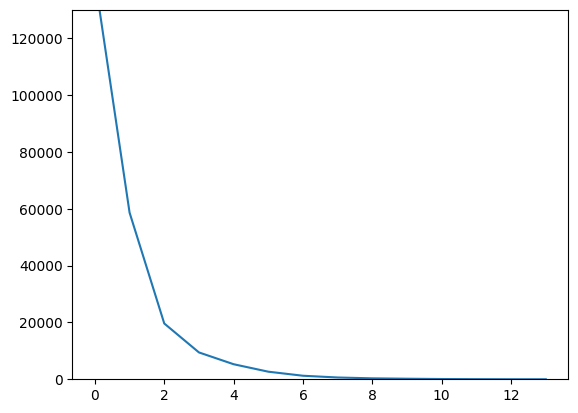

In [10]:
plt.plot(*np.unique(guessing_entropy(round_perm_probas, round_perms_true), return_counts=True))
plt.ylim([0, 130000])

(0.0, 1500000.0)

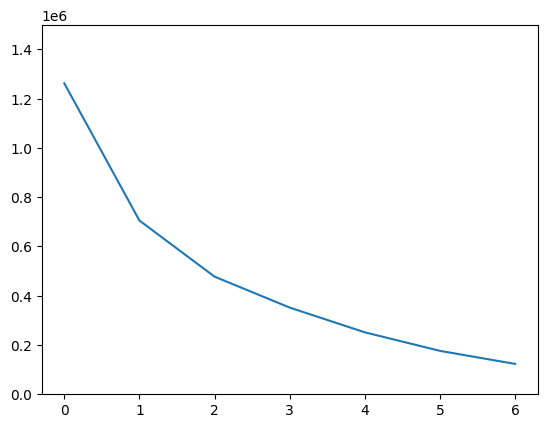

In [11]:
plt.plot(*np.unique(guessing_entropy(copy_perm_probas, copy_perms_true), return_counts=True))
plt.ylim([0, 1500000])

In [12]:
np.count_nonzero(np.argmax(masks_probas, axis=-1) == round_masks_true) / round_masks_true.size

0.0698145423218034

In [13]:
plt.plot(*np.unique(guessing_entropy(masks_probas, round_masks_true), return_counts=True))
plt.ylim([0, 3.5e6])

KeyboardInterrupt: 

In [6]:
from templates import rws_classifications_per_trace, classifications_per_trace, reconstruct_key
_, seeds_extraction = train_test_split(seeds_total, train_size=TRAIN_SIZE, random_state=0)
rws_perm_probas = y_predicted[0]
rws_masks_probas = np.stack([np.stack(y_predicted[keyround_idx:keyround_idx+NR_SHARES], axis=1) for keyround_idx in range(1, 1 + NR_SHARES * KEYROUND_WIDTH_B4, NR_SHARES)], axis=1)

per_trace_rws = rws_classifications_per_trace("per_trace_500000_haar_2_epoch_33_rws.pic", seeds_extraction, rws_perm_probas, rws_masks_probas, parallel=True)

round_perm_probas = y_predicted[1 + NR_SHARES * KEYROUND_WIDTH_B4]
copy_perm_probas = np.stack(y_predicted[1 + NR_SHARES * KEYROUND_WIDTH_B4 + 1:1 + NR_SHARES * KEYROUND_WIDTH_B4 + 1 + (LATEST_ROUND - EARLIEST_ROUND)], axis=1)
masks_probas = np.stack([np.stack([np.stack(y_predicted[block_idx:block_idx+NR_SHARES], axis=1) for block_idx in range(1 + NR_SHARES * KEYROUND_WIDTH_B4 + 1 + (LATEST_ROUND - EARLIEST_ROUND) + 2 * round_idx * BLOCK_WIDTH_B4, 1 + NR_SHARES * KEYROUND_WIDTH_B4 + 1 + (LATEST_ROUND - EARLIEST_ROUND) + 2 * (round_idx + 1) * BLOCK_WIDTH_B4, NR_SHARES)], axis=1) for round_idx in range(EARLIEST_ROUND, LATEST_ROUND)], axis=1)

per_trace_rounds = classifications_per_trace("per_trace_500000_haar_2_epoch_33_rounds.pic", seeds_extraction, round_perm_probas, copy_perm_probas, masks_probas, parallel=True)

per_trace_total = per_trace_rws + per_trace_rounds
recovered_key = reconstruct_key(per_trace_total)

In [17]:
with open("per_trace_500000_haar_2_epoch_33_rws.pic", "rb") as r:
    per_trace_rws = pic.load(r)
with open("per_trace_500000_haar_2_epoch_33_rounds.pic", "rb") as r:
    per_trace_rounds = pic.load(r)
per_trace_total = per_trace_rws + per_trace_rounds
recovered_key = reconstruct_key(per_trace_total)

In [7]:
np.count_nonzero(reconstruct_key(per_trace_rws) == key) / 512

0.107421875

In [8]:
np.count_nonzero(reconstruct_key(per_trace_rounds) == key) / 512

0.08984375

In [9]:
np.count_nonzero(recovered_key == key) / 512

0.125

In [52]:
classifications_per_key_nibble = np.sum(per_trace_total, axis=0)
mean_ranks = compute_mean_ranks(per_trace_total, key, repeat=150)
with open("mean_ranks_500000_haar_2_epoch_17.pic", "wb") as w:
    pic.dump(mean_ranks, w)

0
149
249
349
449
549
649
749
849
949


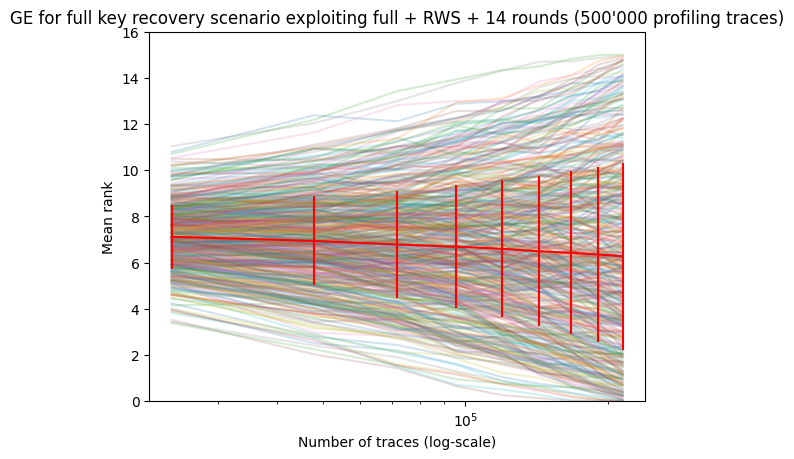

In [54]:
for n, nibble_ranks in enumerate(mean_ranks):
    plt.plot(range(0, per_trace_total.shape[0], per_trace_total.shape[0] // 10)[1:-1], nibble_ranks[1:], label=f"Key nibble {n}", alpha=0.2)
plt.errorbar(range(0, per_trace_total.shape[0], per_trace_total.shape[0] // 10)[1:-1], np.mean(mean_ranks, axis=0)[1:], np.std(mean_ranks, axis=0)[1:], color="red")
plt.xscale("log")
plt.title("GE for full key recovery scenario exploiting full + RWS + 14 rounds (500'000 profiling traces)")
plt.xlabel("Number of traces (log-scale)")
plt.ylabel("Mean rank")
plt.ylim([0, 16])
#plt.legend()
plt.show()

## Even more data

In [3]:
with open("seeds_key_1000000.pic", "rb") as r:
    seeds_total, key = pic.load(r)

## 240'000 extraction traces, original traces, one model per round, 4 models for RWS

In [4]:
TRAIN_SIZE = 750_000

In [5]:
_, seeds_extraction = train_test_split(seeds_total, train_size=TRAIN_SIZE, random_state=0)

with open("y_extraction_750000_orig_rws_perm.pic", "rb") as r:
    rws_perm_probas = pic.load(r)
rws_masks_probas = np.zeros((seeds_extraction.shape[0], KEYROUND_WIDTH_B4, NR_SHARES, len(KEY_ALPHABET)), dtype=np.float64)
for i in range(0, 4):
    subkey = np.arange(i * (KEYROUND_WIDTH_B4 // 4), (i + 1) * (KEYROUND_WIDTH_B4 // 4) if i < 3 else KEYROUND_WIDTH_B4)
    with open(f"y_extraction_750000_orig_rws_{i}.pic", "rb") as r:
        y_predicted = pic.load(r)
        rws_masks_probas[:, subkey, :, :] = np.stack([np.stack(y_predicted[keyround_idx:keyround_idx+NR_SHARES], axis=1) for keyround_idx in range(0, NR_SHARES * len(subkey), NR_SHARES)], axis=1)

with open("y_extraction_750000_orig_round_perm.pic", "rb") as r:
    round_perm_probas = pic.load(r)
copy_perm_probas = np.zeros((seeds_extraction.shape[0], KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4, BLOCK_WIDTH_B4), dtype=np.float64)
masks_probas = np.zeros((seeds_extraction.shape[0], KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4, BLOCK_WIDTH_B4, NR_SHARES, len(KEY_ALPHABET)), dtype=np.float64)
for round_idx in range(0, KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4):
    with open(f"y_extraction_750000_orig_round_{round_idx}_adjusted.pic", "rb") as r:
        y_predicted = pic.load(r)
        copy_perm_probas[:, round_idx, :] = y_predicted[0]
        masks_probas[:, round_idx, :, :, :] = np.stack([np.stack(y_predicted[block_idx:block_idx+NR_SHARES], axis=1) for block_idx in range(1, 1 + NR_SHARES * BLOCK_WIDTH_B4, NR_SHARES)], axis=1)

In [11]:
from templates import rws_classifications_per_trace, classifications_per_trace, reconstruct_key

per_trace_rws = rws_classifications_per_trace("per_trace_750000_orig_rws_4_quarters.pic", seeds_extraction, rws_perm_probas, rws_masks_probas, parallel=True)

per_trace_rounds = classifications_per_trace("per_trace_750000_orig_all_rounds.pic", seeds_extraction, round_perm_probas, copy_perm_probas, masks_probas, parallel=True)

per_trace_total = per_trace_rws + per_trace_rounds
recovered_key = reconstruct_key(per_trace_total)

In [46]:
with open("per_trace_750000_orig_rws_4_quarters.pic", "rb") as r:
    per_trace_rws = pic.load(r)
with open("per_trace_750000_orig_all_rounds.pic", "rb") as r:
    per_trace_rounds = pic.load(r)
per_trace_total = per_trace_rws + per_trace_rounds
recovered_key = reconstruct_key(per_trace_total)

In [12]:
np.count_nonzero(reconstruct_key(per_trace_rws) == key) / 512

0.998046875

In [13]:
np.count_nonzero(reconstruct_key(per_trace_rounds) == key) / 512

0.65234375

In [14]:
np.count_nonzero(recovered_key == key) / 512

0.998046875

Ok that's better but it could just be from the fact that we have 250'000 extraction trace instead of 100'000. Not from the fact that my models are better.

In [15]:
np.random.seed(0)
subsample = np.random.choice(per_trace_rws.shape[0], size=100_000, replace=False)

In [16]:
np.count_nonzero(reconstruct_key(per_trace_rws[subsample]) == key) / 512

0.951171875

In [17]:
np.count_nonzero(reconstruct_key(per_trace_rounds[subsample]) == key) / 512

0.380859375

In [18]:
np.count_nonzero(reconstruct_key(per_trace_rws[subsample] + per_trace_rounds[subsample]) == key) / 512

0.95703125

In [19]:
mean_ranks = compute_mean_ranks(per_trace_total, key, repeat=100)
with open("mean_ranks_750000_rws_4_quarters_all_rounds.pic", "wb") as w:
    pic.dump(mean_ranks, w)

0
19
29
39
49
59
69
79
89
99


In [47]:
with open("mean_ranks_750000_rws_4_quarters_all_rounds.pic", "rb") as r:
    mean_ranks = pic.load(r)

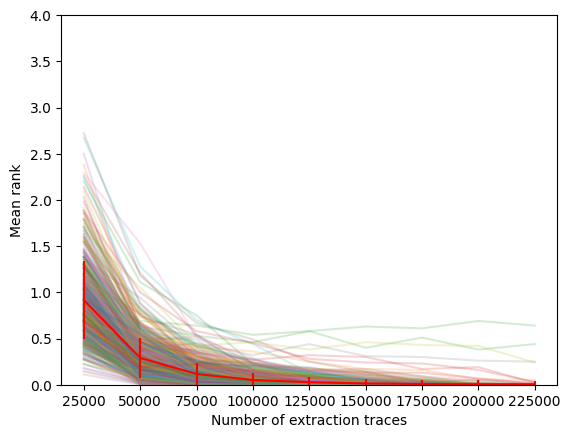

In [54]:
for n, nibble_ranks in enumerate(mean_ranks):
    plt.plot([i * per_trace_total.shape[0] // 10 for i in range(10)][1:], nibble_ranks[1:], label=f"Key nibble {n}", alpha=0.2)
plt.errorbar([i * per_trace_total.shape[0] // 10 for i in range(10)][1:], np.mean(mean_ranks, axis=0)[1:], np.std(mean_ranks, axis=0)[1:], color="red")
#plt.xscale("log")
#plt.title("GE graph with 20 neural networks (750'000 profiling traces)")
plt.xlabel("Number of extraction traces")
plt.ylabel("Mean rank")
plt.ylim([0, 4])
#plt.legend()
plt.show()

In [47]:
with open("labels_1000000.pic", "rb") as r:
    rws_perms_true, round_perms_true, copy_perms_true, rws_masks_true, round_masks_true = pic.load(r)
    _, rws_perms_true, _, round_perms_true, _, copy_perms_true, _, rws_masks_true, _, round_masks_true = train_test_split(np.moveaxis(rws_perms_true, -1, 0), np.moveaxis(round_perms_true, -1, 0), np.moveaxis(copy_perms_true, -1, 0), np.moveaxis(rws_masks_true, -1, 0), np.moveaxis(round_masks_true, -1, 0), train_size=TRAIN_SIZE, random_state=0)
    #rws_perms_true, round_perms_true, copy_perms_true, rws_masks_true, round_masks_true = np.moveaxis(rws_perms_true, 0, -1), np.moveaxis(round_perms_true, 0, -1), np.moveaxis(copy_perms_true, 0, -1), np.moveaxis(rws_masks_true, 0, -1), np.moveaxis(round_masks_true, 0, -1)

In [48]:
np.count_nonzero(np.argmax(rws_perm_probas, axis=-1) == rws_perms_true) / rws_perms_true.shape[0]

0.9934959739838959

In [49]:
np.mean(guessing_entropy(rws_perm_probas, rws_perms_true))

0.01198004792019168

In [50]:
np.count_nonzero(np.argmax(round_perm_probas, axis=-1) == round_perms_true) / round_perms_true.shape[0]

0.7510590042360169

In [51]:
np.mean(guessing_entropy(round_perm_probas, round_perms_true))

0.38372953491813966

In [71]:
test_accuracies = []
for round_idx in range(copy_perms_true.shape[1]):
    test_accuracies.append(np.count_nonzero(np.argmax(copy_perm_probas[:, round_idx, :], axis=-1) == copy_perms_true[:, round_idx]) / copy_perms_true.shape[0])
print(f"{np.mean(test_accuracies)} +/- {np.std(test_accuracies)}")

0.602295552039351 +/- 0.0666007463399703


In [72]:
test_mean_ranks = []
for round_idx in range(copy_perms_true.shape[1]):
    test_mean_ranks.append(np.mean(guessing_entropy(copy_perm_probas[:, round_idx, :], copy_perms_true[:, round_idx])))
print(f"{np.mean(test_mean_ranks)} +/- {np.std(test_mean_ranks)}")

0.9070807711802277 +/- 0.187441017183112


In [73]:
test_accuracies = []
for keyround_idx in range(rws_masks_true.shape[1]):
    test_accuracies.append(np.count_nonzero(np.argmax(rws_masks_probas[:, keyround_idx, :], axis=-1) == rws_masks_true[:, keyround_idx]) / (rws_masks_true.shape[0] * rws_masks_true.shape[2]))
print(f"{np.mean(test_accuracies)} +/- {np.std(test_accuracies)}")

0.09584615889483966 +/- 0.002378252319697342


In [74]:
test_mean_ranks = []
for keyround_idx in range(rws_masks_true.shape[1]):
    test_mean_ranks.append(np.mean(guessing_entropy(rws_masks_probas[:, keyround_idx, :], rws_masks_true[:, keyround_idx])))
print(f"{np.mean(test_mean_ranks)} +/- {np.std(test_mean_ranks)}")

6.328846029669833 +/- 0.07790270096519042


In [76]:
test_accuracies = []
for round_idx in range(round_masks_true.shape[1]):
    for block_idx in range(round_masks_true.shape[2]):
        test_accuracies.append(np.count_nonzero(np.argmax(masks_probas[:, round_idx, block_idx, :], axis=-1) == round_masks_true[:, round_idx, block_idx]) / (round_masks_true.shape[0] * round_masks_true.shape[3]))
print(f"{np.mean(test_accuracies)} +/- {np.std(test_accuracies)}")

0.0843955416637993 +/- 0.005359034113553631


In [77]:
test_mean_ranks = []
for round_idx in range(round_masks_true.shape[1]):
    for block_idx in range(round_masks_true.shape[2]):
        test_mean_ranks.append(np.mean(guessing_entropy(masks_probas[:, round_idx, block_idx, :], round_masks_true[:, round_idx, block_idx])))
print(f"{np.mean(test_mean_ranks)} +/- {np.std(test_mean_ranks)}")

6.722869564947647 +/- 0.17863844206107565
